In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 91% 55.0M/60.3M [00:00<00:00, 83.1MB/s]
100% 60.3M/60.3M [00:00<00:00, 87.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
from PIL import Image
import os

def check_image_corruption(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return True  # Image is not corrupt
    except Exception as e:
        print(f"Error checking image {image_path}: {e}")
        return False  # Image is corrupt

def check_directory_images(directory_path):
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Adjust file extensions as needed
                image_path = os.path.join(root, filename)
                if check_image_corruption(image_path):
                    pass
                else:
                    print(f"{image_path} is corrupt.")

# Replace 'your_directory_path' with the actual path to your directory
directory_path = '/content/train'
check_directory_images(directory_path)

In [ ]:
import os
from PIL import Image

# Path to the directory containing images
image_directory = 'content/train/'

# Initialize a counter for corrupted images
corrupted_count = 0

# Recursively go through all subdirectories and files
for root, dirs, files in os.walk(image_directory):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other image extensions if needed
            file_path = os.path.join(root, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifies if it's a valid image file
            except (FileNotFoundError, OSError):
                print(f"Corrupted or missing image: {file_path}")
                corrupted_count += 1

# Print the total number of corrupted images
print(f"Total number of corrupted images: {corrupted_count}")


Total number of corrupted images: 0



Label: happy


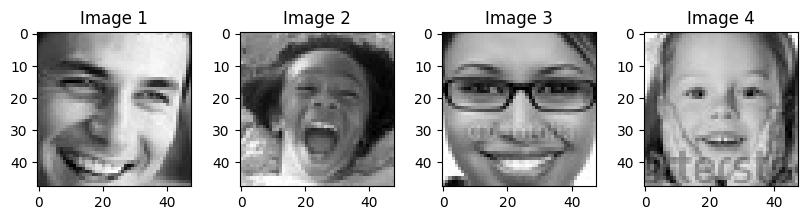


Label: disgust


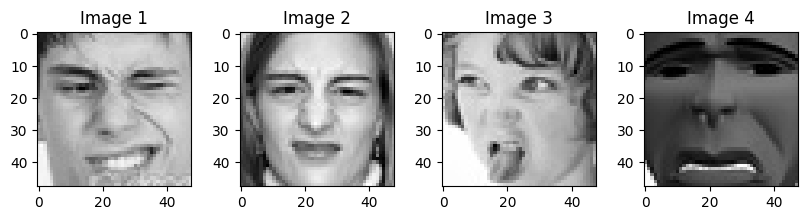


Label: sad


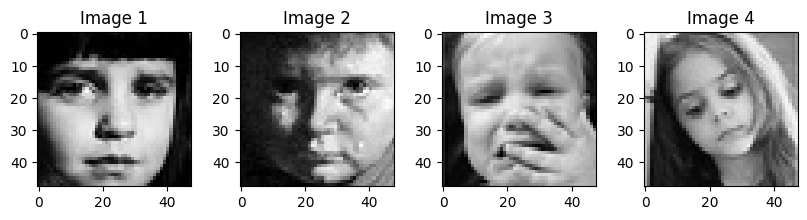


Label: surprise


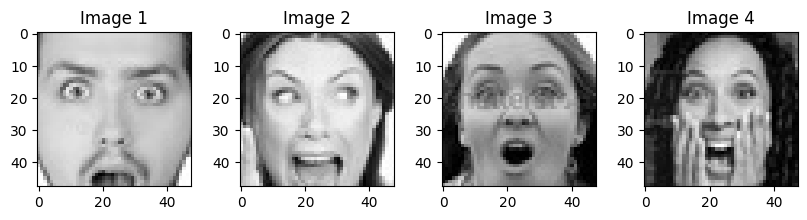


Label: angry


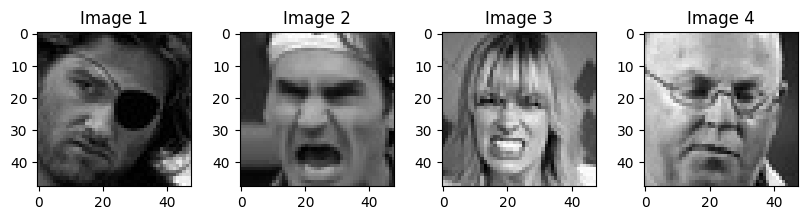


Label: neutral


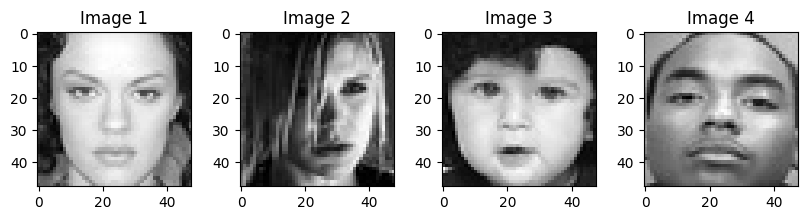


Label: fear


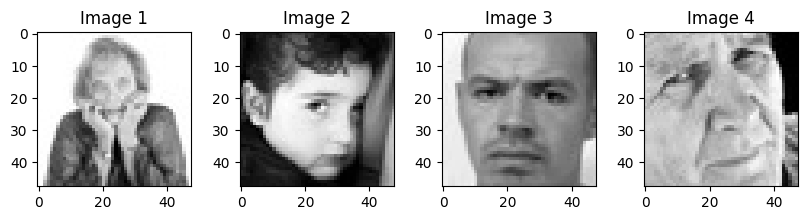

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random

def display_random_bw_images(directory_path, images_per_row=4):
    """Displays a specified number of random black and white images from each label folder within the specified directory.

    Args:
        directory_path: The path to the directory containing the label folders.
        images_per_row: The number of images to display in each row.
    """

    for label_folder in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label_folder)
        if os.path.isdir(label_path):
            print(f"\nLabel: {label_folder}")

            # Get a list of image files
            image_files = [f for f in os.listdir(label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

            # Choose random images
            if image_files:
                random_images = random.sample(image_files, min(images_per_row, len(image_files)))

                # Create a figure and subplots
                fig, axes = plt.subplots(1, images_per_row, figsize=(10, 2))

                for i, image_file in enumerate(random_images):
                    image_path = os.path.join(label_path, image_file)
                    img = cv2.imread(image_path)
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    axes[i].imshow(gray_img, cmap='gray')
                    axes[i].set_title(f"Image {i + 1}")

                plt.show()

# Replace 'content/train' with the actual path to your directory
directory_path = '/content/train'
display_random_bw_images(directory_path)

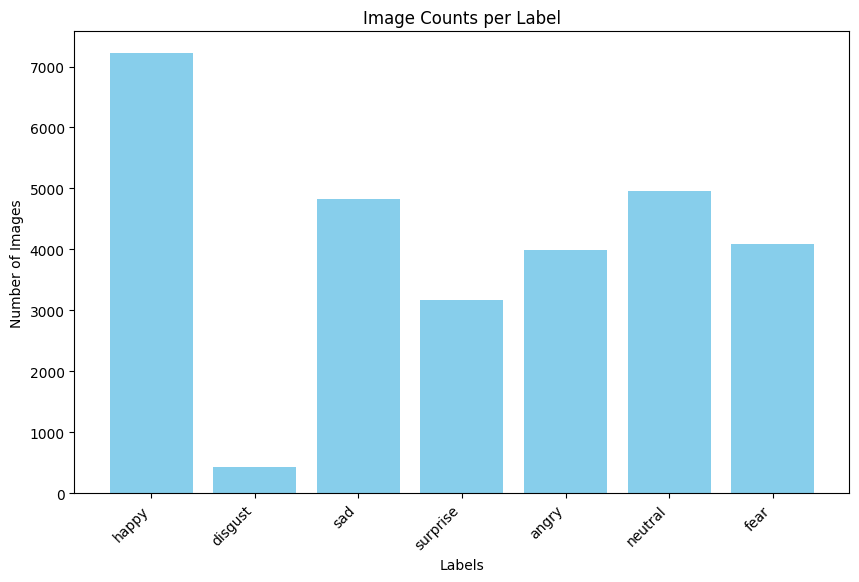

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images_by_label(directory_path):
    label_counts = {}
    for label_folder in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label_folder)
        if os.path.isdir(label_path):
            image_count = len([f for f in os.listdir(label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
            label_counts[label_folder] = image_count
    return label_counts

def create_bar_graph(label_counts):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title('Image Counts per Label')
    plt.xticks(rotation=45, ha='right')
    plt.show()

directory_path = '/content/train'
label_counts = count_images_by_label(directory_path)
create_bar_graph(label_counts)

In [ ]:
# generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)


train_ds = data_gen.flow_from_directory(
    directory = '/content/train',
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    batch_size=60,
    target_size=(256,256)
)

validation_ds = data_gen.flow_from_directory(
    directory = '/content/train',
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    batch_size=60,
    target_size=(256,256)
)

test_ds = data_gen.flow_from_directory(
    directory = '/content/test',
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=60,
    target_size=(256,256)
)


Found 22968 images belonging to 7 classes.
Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',kernel_initializer='glorot_uniform',activation='relu',input_shape=(256,256,1)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,460,359 (13.20 MB)

 Trainable params: 3,460,359 (13.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history =model.fit(train_ds,epochs=20,validation_data=validation_ds)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 87s 191ms/step - accuracy: 0.2456 - loss: 1.8214 - val_accuracy: 0.3736 - val_loss: 1.6188
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 112s 144ms/step - accuracy: 0.3730 - loss: 1.6029 - val_accuracy: 0.4741 - val_loss: 1.3864
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 87s 157ms/step - accuracy: 0.4466 - loss: 1.4339 - val_accuracy: 0.5210 - val_loss: 1.2863
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.5057 - loss: 1.3028 - val_accuracy: 0.5705 - val_loss: 1.1421
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.5394 - loss: 1.2074 - val_accuracy: 0.6231 - val_loss: 1.0115
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - accuracy: 0.5886 - loss: 1.0910 - val_accuracy: 0.6617 - val_loss: 0.9164
Epoch 7/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 156ms/step - accuracy: 0.6282 - loss: 0.9869 - val_accuracy: 0.7349 - val_loss: 0.7535
Epoch 8/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 157ms/step - accuracy: 0.6761 - loss: 0.8546 - va

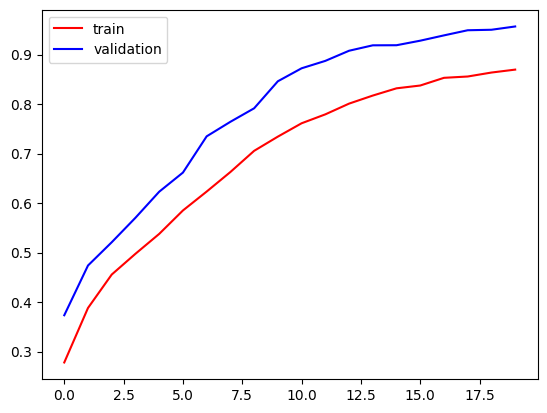

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(train_ds)
test_loss, test_accu = model.evaluate(test_ds)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9575 - loss: 0.1434
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5191 - loss: 2.5516
final train accuracy = 95.69 , validation accuracy = 50.77


In [ ]:
test_ds.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5029 - loss: 2.6955
Test accuracy: 0.507662296295166
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


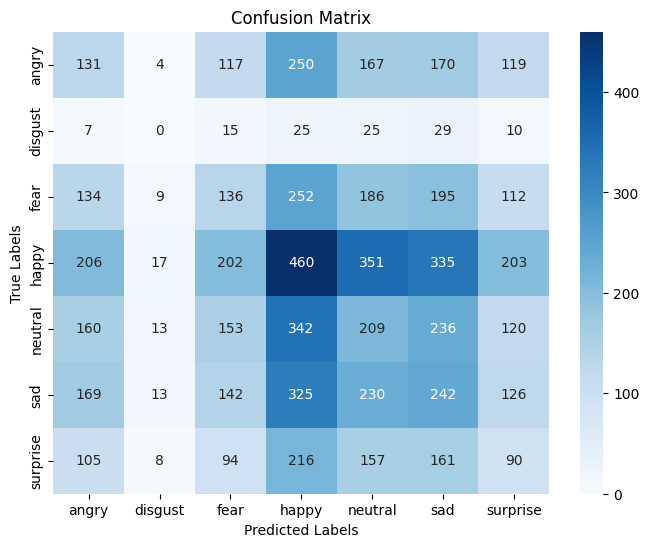

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

# Get predictions for the test set
y_pred = model.predict(test_ds)
y_true = test_ds.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
class_labels = list(test_ds.class_indices.keys())
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# training data model using augmented images

In [ ]:
# generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen1=ImageDataGenerator(rotation_range=10,shear_range=0.2,
    zoom_range=0.25,horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,validation_split=0.2)


train_ds1 = data_gen1.flow_from_directory(
    directory = '/content/train',
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    batch_size=64,
    target_size=(256,256)
)

validation_ds1 = data_gen1.flow_from_directory(
    directory = '/content/train',
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=64,
    subset='validation',
    target_size=(256,256)
)
test_gen=ImageDataGenerator(rescale=1./255)
test_ds1 = test_gen.flow_from_directory(
    directory = '/content/test',
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=64,
    target_size=(256,256)
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# create CNN model
from tensorflow.keras import regularizers

model1 = Sequential()

model1.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,1)))
model1.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model1.add(BatchNormalization())

model1.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model1.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model1.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model1.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model1.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
model1.add(BatchNormalization())



model1.add(Flatten())

model1.add(Dense(1024,activation='relu'))



model1.add(Dense(7,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,084,871 (49.91 MB)

 Trainable params: 13,082,951 (49.91 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Callback to save the model checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger


# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [ earlystop, reduce_lr]


# Assuming early stopping as part of callbacks
history = model1.fit(
    train_ds1,

    epochs=15,
    validation_data=validation_ds1,

    callbacks=callbacks
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.2325 - loss: 3.6746 - val_accuracy: 0.2513 - val_loss: 2.0082 - learning_rate: 0.0010
Epoch 2/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 294s 748ms/step - accuracy: 0.2580 - loss: 1.8833 - val_accuracy: 0.2493 - val_loss: 2.0406 - learning_rate: 0.0010
Epoch 3/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 321s 746ms/step - accuracy: 0.2790 - loss: 1.7647 - val_accuracy: 0.2392 - val_loss: 1.8876 - learning_rate: 0.0010
Epoch 4/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 320s 741ms/step - accuracy: 0.3142 - loss: 1.7126 - val_accuracy: 0.3215 - val_loss: 1.7110 - learning_rate: 0.0010
Epoch 5/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 320s 737ms/step - accuracy: 0.3545 - loss: 1.6320 - val_accuracy: 0.1707 - val_loss: 2.1083 - learning_rate: 0.0010
Epoch 6/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 268s 736ms/step - accuracy: 0.4056 - loss: 1.5392 - val_accuracy: 0.3660 - val_loss: 1.6168 - learning_rate: 0.0010
Epoch 7/15
359/359 ━━━━━━━━━━━━━━━━━━━━ 319s 730ms/step - accuracy: 0.4436 - l

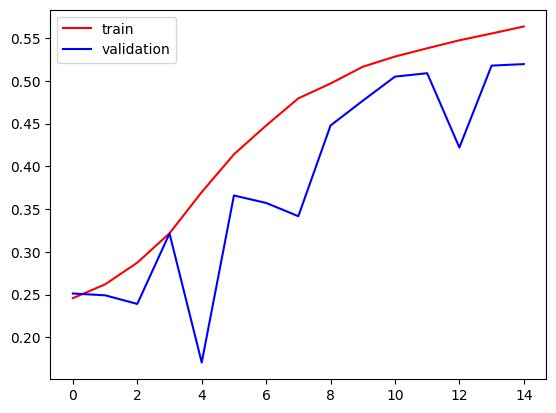

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
train_loss, train_accu = model1.evaluate(train_ds1)
test_loss, test_accu = model1.evaluate(test_ds1)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 150s 416ms/step - accuracy: 0.5298 - loss: 1.2372
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5679 - loss: 1.1343
final train accuracy = 53.10 , validation accuracy = 55.63


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.5586 - loss: 1.1603
Test accuracy: 0.5562831163406372
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step


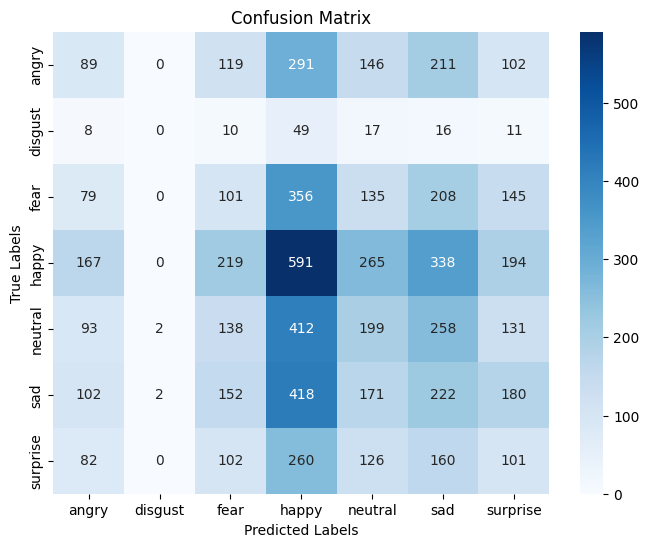

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model1.evaluate(test_ds1)
print('Test accuracy:', test_acc)

# Get predictions for the test set
y_pred = model1.predict(test_ds1)
y_true = test_ds1.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
class_labels = list(test_ds1.class_indices.keys())
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_labels))

              precision    recall  f1-score   support

           0       0.14      0.09      0.11       958
           1       0.00      0.00      0.00       111
           2       0.12      0.10      0.11      1024
           3       0.25      0.33      0.28      1774
           4       0.19      0.16      0.17      1233
           5       0.16      0.18      0.17      1247
           6       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



In [ ]:
#transfer learning(feature extraction)

In [ ]:
# generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen1=ImageDataGenerator(rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest')


train_ds1 = data_gen1.flow_from_directory(
    directory = '/content/train',
    class_mode='categorical',

    subset='training',color_mode='rgb',
    batch_size=64,
    target_size=(48,48),shuffle=True
)


test_gen=ImageDataGenerator(rescale=1./255)
test_ds1 = test_gen.flow_from_directory(
    directory = '/content/test',color_mode='rgb',
    class_mode='categorical',

    batch_size=64,
    target_size=(48,48)
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(input_shape=(48,48,3),weights='imagenet',include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in vgg.layers[:-3]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
model2=Sequential()
model2.add(tf.keras.Input(shape=(48, 48, 3)))
model2.add(vgg)
model2.add(Flatten())
model2.add(Dense(1024,activation='relu',kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
model2.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model2.add(Dropout(0.5))
model2.add(Dense(7,activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,768,391 (60.15 MB)

 Trainable params: 5,773,319 (22.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
classes=np.array(train_ds1.classes)
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(classes),y=classes)
class_weights=dict(enumerate(class_weights))
print(class_weights)


{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [ earlystop, reduce_lr]
train_steps_per_epoch = train_ds1.samples // train_ds1.batch_size + 1
#validation_steps_epoch = validation_ds1.samples // validation_ds1.batch_size + 1
test_steps_epoch = test_ds1.samples // test_ds1.batch_size + 1

In [ ]:
history5=model2.fit(train_ds1,epochs=50,validation_data=test_ds1,callbacks=callbacks,
                    class_weight=class_weights)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.2449 - loss: 1.7379 - val_accuracy: 0.3639 - val_loss: 1.6340 - learning_rate: 1.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.3234 - loss: 1.7120 - val_accuracy: 0.4164 - val_loss: 1.5322 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.3473 - loss: 1.6144 - val_accuracy: 0.4125 - val_loss: 1.5384 - learning_rate: 1.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.3685 - loss: 1.5688 - val_accuracy: 0.4172 - val_loss: 1.5112 - learning_rate: 1.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.3911 - loss: 1.5330 - val_accuracy: 0.4549 - val_loss: 1.4486 - learning_rate: 1.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - accuracy: 0.4100 - loss: 1.5115 - val_accuracy: 0.4551 - val_loss: 1.4383 - learning_rate: 1.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 50s 11

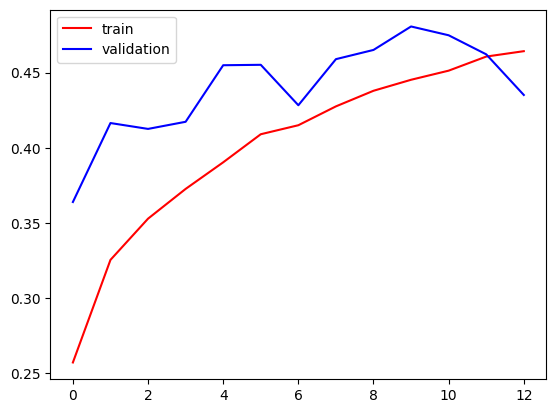

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history5.history['accuracy'],color='red',label='train')
plt.plot(history5.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

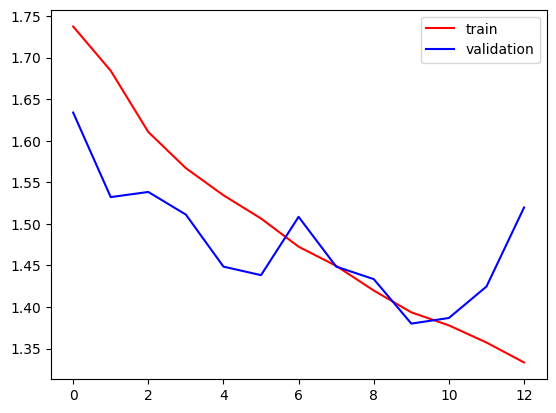

In [ ]:
plt.plot(history5.history['loss'],color='red',label='train')
plt.plot(history5.history['val_loss'],color='blue',label='validation')
plt.legend()
plt

In [ ]:
train_loss, train_accu = model2.evaluate(train_ds1)
test_loss, test_accu = model2.evaluate(test_ds1)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.4747 - loss: 1.3761
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4714 - loss: 1.3966
final train accuracy = 47.22 , validation accuracy = 48.06


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4893 - loss: 1.3686
Test accuracy: 0.48063528537750244
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


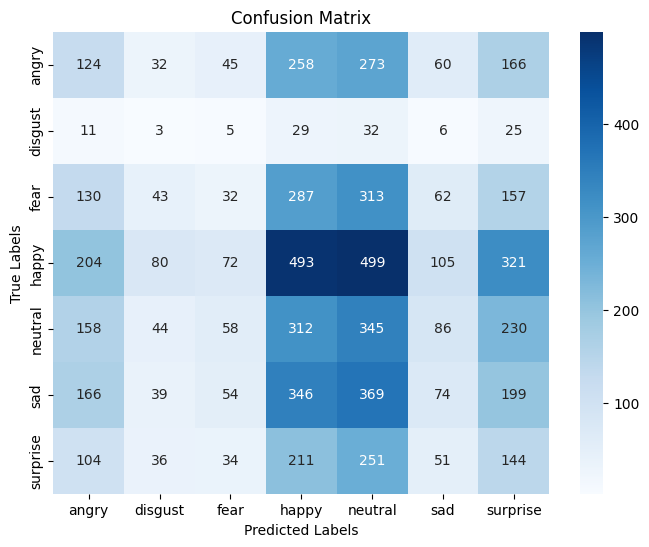

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(test_ds1)
print('Test accuracy:', test_acc)

# Get predictions for the test set
y_pred = model2.predict(test_ds1)
y_true = test_ds1.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
class_labels = list(test_ds1.class_indices.keys())
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# resnet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(48, 48, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
model3=Sequential()
model3.add(tf.keras.Input(shape=(48, 48, 3)))
model3.add(ResNet50V2)
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Flatten())
#model3.add(GlobalAveragePooling2D())
model3.add(Dense(1024,activation='relu',kernel_initializer='he_normal'))
model3.add(Dropout(0.3))
model3.add(BatchNormalization())
model3.add(Dense(7,activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
               loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',

                          patience=7,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              #min_delta=0.0001
                              )

callbacks = [ earlystop, reduce_lr]
train_steps_per_epoch = train_ds1.samples // train_ds1.batch_size + 1
#validation_steps_epoch = validation_ds1.samples // validation_ds1.batch_size + 1
test_steps_epoch = test_ds1.samples // test_ds1.batch_size + 1

In [ ]:
history4=model3.fit(train_ds1,epochs=50,validation_data=test_ds1,callbacks=callbacks,
                    class_weight=class_weights)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 94s 149ms/step - accuracy: 0.1747 - loss: 2.4112 - val_accuracy: 0.2988 - val_loss: 1.9411 - learning_rate: 1.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 50s 108ms/step - accuracy: 0.2407 - loss: 2.0535 - val_accuracy: 0.3789 - val_loss: 1.6985 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.2977 - loss: 1.8566 - val_accuracy: 0.3796 - val_loss: 1.6628 - learning_rate: 1.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.3135 - loss: 1.7963 - val_accuracy: 0.4355 - val_loss: 1.5900 - learning_rate: 1.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.3458 - loss: 1.7001 - val_accuracy: 0.4223 - val_loss: 1.5125 - learning_rate: 1.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - accuracy: 0.3818 - loss: 1.6114 - val_accuracy: 0.4588 - val_loss: 1.4451 - learning_rate: 1.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - 

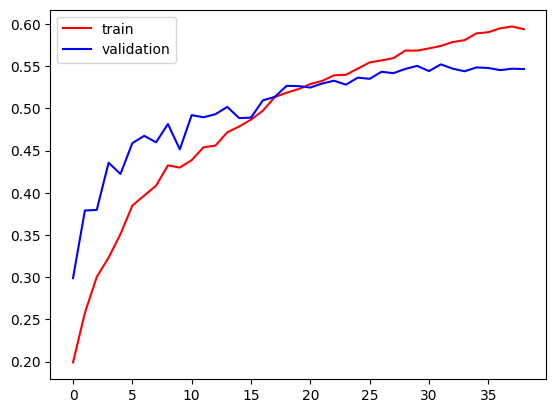

In [ ]:
plt.plot(history4.history['accuracy'],color='red',label='train')
plt.plot(history4.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

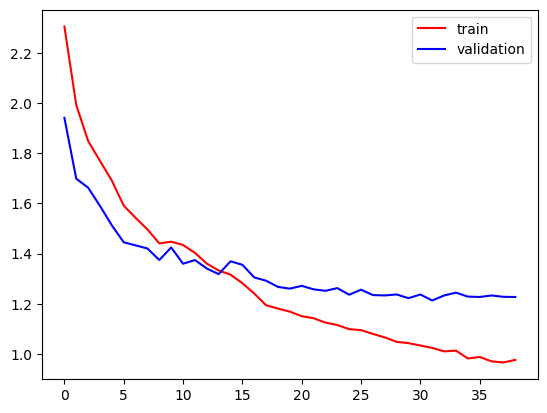

In [ ]:
plt.plot(history4.history['loss'],color='red',label='train')
plt.plot(history4.history['val_loss'],color='blue',label='validation')
plt.legend()
plt

In [ ]:
train_loss, train_accu = model3.evaluate(train_ds1)
test_loss, test_accu = model3.evaluate(test_ds1)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.6050 - loss: 1.0654
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5492 - loss: 1.2172
final train accuracy = 60.73 , validation accuracy = 55.21


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5579 - loss: 1.2026
Test accuracy: 0.5521036386489868
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


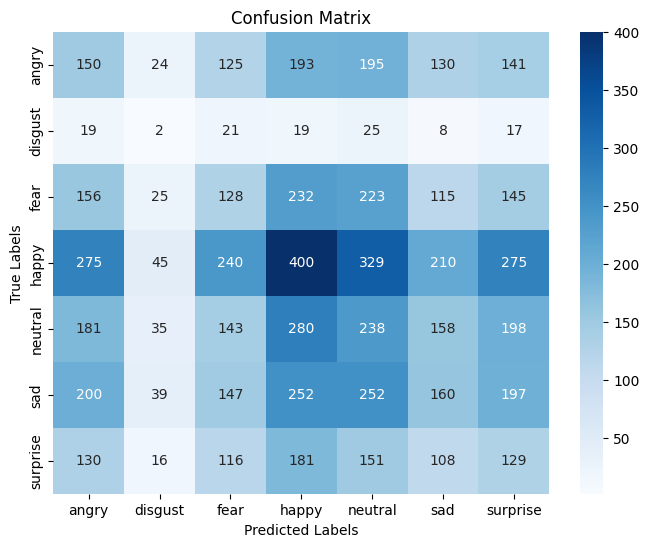

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(test_ds1)
print('Test accuracy:', test_acc)

# Get predictions for the test set
y_pred = model3.predict(test_ds1)
y_true = test_ds1.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
class_labels = list(test_ds1.class_indices.keys())
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_labels))

              precision    recall  f1-score   support

           0       0.14      0.16      0.14       958
           1       0.02      0.03      0.02       111
           2       0.13      0.12      0.12      1024
           3       0.25      0.22      0.23      1774
           4       0.19      0.21      0.20      1233
           5       0.18      0.13      0.15      1247
           6       0.11      0.14      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178

